In [14]:
from pathlib import Path
from rdkit import Chem
from iotbx.data_manager import DataManager
import numpy as np
import sys
import tqdm
from multiprocessing import Pool
from contextlib import closing
sys.path.append("..")

from phenixml.fragmentation.fragments import MolContainer, Fragment
from phenixml.fragmentation.fragmenters import MoleculeFragmenter, BondFragmenter, AngleFragmenter
from phenixml.featurizers.fragments.fingerprints import MorganFeaturizer, RDKFingerprint
from phenixml.labelers.fragment_labelers import BondFragmentLabeler, AngleFragmentLabeler
from phenixml.featurizers.fragments.ani_featurizer import ANIFeaturizer

from phenixml.fragments.nn_fragments import FragmentKNN
from phenixml.fragmentation.display import FragmentDisplay
display = FragmentDisplay()

from phenixml.visualization.plotting import plot_geom_eval
import matplotlib.pyplot as plt

In [2]:
# get molecules
mol_dir = "/dev/shm/cschlick/geostd_passed/"
containers = MolContainer.from_folder(mol_dir,max_files=None)

In [3]:
%%time
# Fragment and featurize

def worker(container):
  fragmenter = BondFragmenter(exclude_elements=["H"])
  fragments = fragmenter(container)
  try:
    features = ANIFeaturizer.from_fragments_atom_centric(fragments,return_flat=True)
    return (fragments,features)
  except:
    return None

work = containers
results = []
with closing(Pool(processes=64)) as pool:
  for result in tqdm.tqdm(pool.imap_unordered(worker, work), total=len(work)):
      results.append(result)
  pool.terminate()

  
fragments = []
features = []
for result in results:
  if result is not None:
    fragments+= result[0]
    features.append(result[1])
features = np.vstack(features)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16150/16150 [01:08<00:00, 235.06it/s]


CPU times: user 59 s, sys: 25.7 s, total: 1min 24s
Wall time: 1min 14s


In [4]:
%%time
# label the fragments
labeler = BondFragmentLabeler()
labels = labeler(fragments)

CPU times: user 14.5 s, sys: 74.4 ms, total: 14.5 s
Wall time: 14.5 s


In [5]:
# train/test split
from sklearn.model_selection import train_test_split
inds = np.arange(len(fragments))
train,test = train_test_split(inds,test_size=0.2)
feat_train, feat_test = features[train], features[test]
labels_train, labels_test = labels[train], labels[test]
frags_train = [fragments[i] for i in train]
frags_test = [fragments[i] for i in test]

## kNN

In [6]:
%%time
# Build the pynndescent index
knn = FragmentKNN(frags_train,feat_train)

CPU times: user 1h 9min 41s, sys: 2min 13s, total: 1h 11min 55s
Wall time: 4min 12s


In [9]:
# choose a single query to illustrate kNN search
query_idx = 200
query_frag = frags_test[query_idx]
query_feature = feat_test[query_idx]
query_label = labels_test[query_idx]

nbrs,inds = knn.query(query_feature,k=20, return_ind=True)
nbr_labels = labels_train[inds]

In [1]:
display(query_frag,hideHs=True,size=(300,300))

NameError: name 'query_frag' is not defined

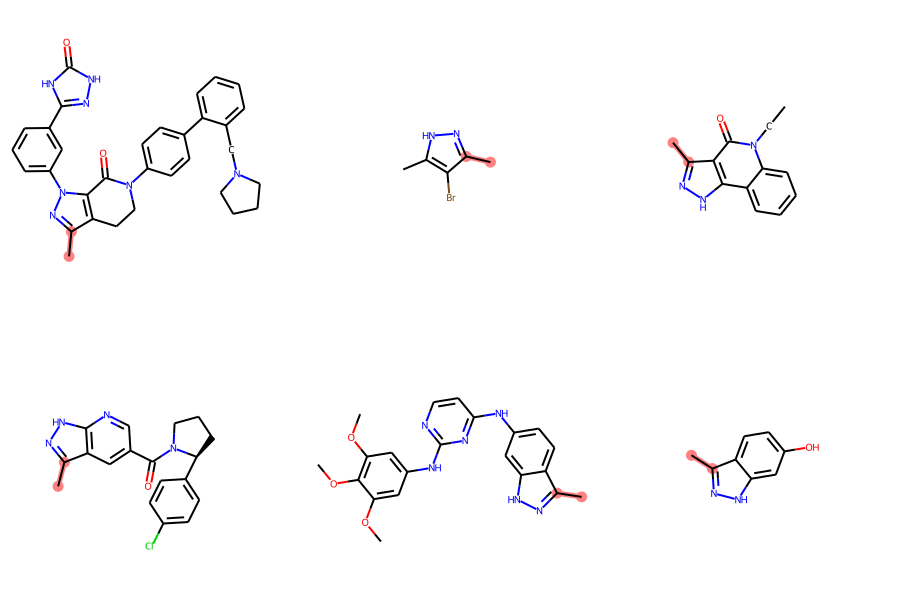

In [11]:
display(nbrs)

In [12]:
# kNN Regression
# Query the knn for the whole test set
nbrs,inds = knn.query(feat_test,k=20, return_ind=True)
nbr_labels = labels_train[inds]

In [13]:
nbr_mean_label = nbr_labels.mean(axis=1)[:,0]

In [15]:
labels_test = labels_test[:,0]

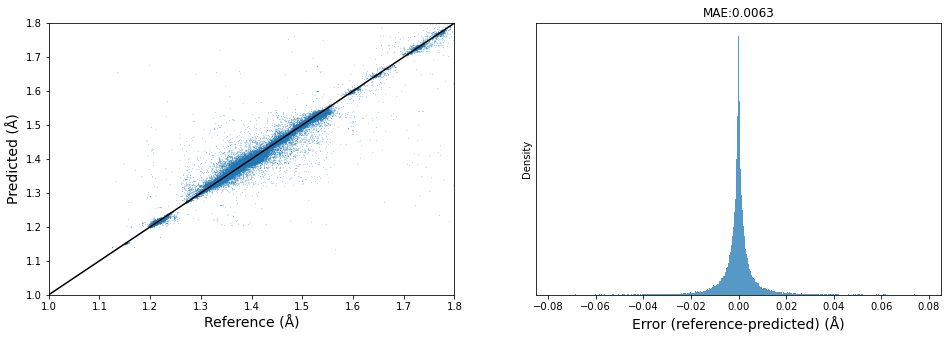

In [16]:
plot_geom_eval(labels_test,nbr_mean_label,mode="bond")

## MLP Regression

In [19]:
import torch
from phenixml.models.feature_regression import FeatureModel

In [20]:
model = FeatureModel(feat_train.shape[1],256,1,n_hid_layers=2)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()

In [23]:
# set up tensors
gpu = True
feat_train_t = torch.tensor(feat_train,dtype=torch.get_default_dtype())
feat_test_t = torch.tensor(feat_test,dtype=torch.get_default_dtype())
labels_train_t = torch.tensor(labels_train,dtype=torch.get_default_dtype())

gpuid = 0
if gpu:
  feat_train_t = feat_train_t.to("cuda:"+str(gpuid))
  labels_train_t = labels_train_t.to("cuda:"+str(gpuid))
  model = model.to("cuda:"+str(gpuid))

In [24]:
# train
epoch_losses = []
n_epoch=2000


for epoch in tqdm.tqdm(range(n_epoch)):
    
  pred = model(feat_train_t)
  loss = metric(pred,labels_train_t)
  opt.zero_grad()
  loss.backward()
  opt.step()
  
  epoch_losses.append(loss.item())
  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:51<00:00,  8.64it/s]


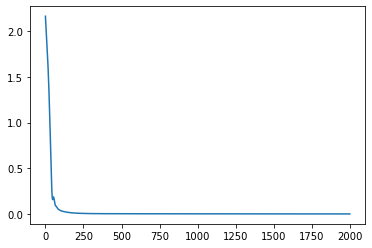

In [106]:
def to_np(tensor):
  return tensor.detach().cpu().numpy()

plt.plot(epoch_losses)

In [107]:
model = model.to("cpu")
pred = model(feat_test_t)

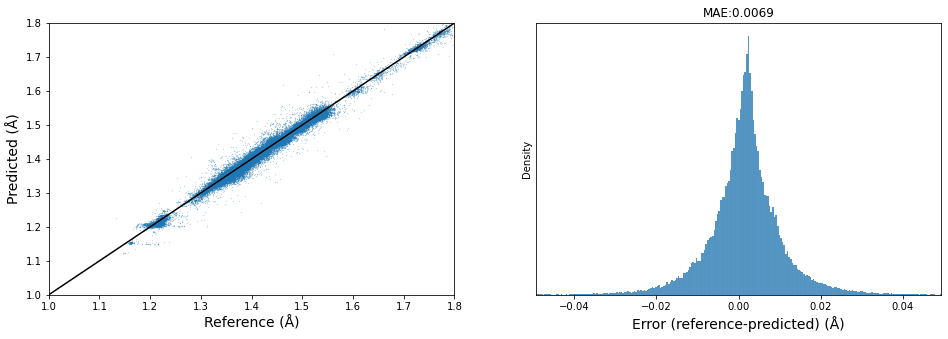

In [108]:
plot_geom_eval(labels_test,to_np(pred),mode="bond")